In [1]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import matplotlib.pyplot as plt
from tesser import util
from tesser import network
from tesser import rsa
plt.rcParams['figure.figsize'] = [10, 10]

/opt/anaconda3/envs/tesser_successor/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
###########
#DIRECTORY#
###########
#need to change path depending on whether you're using laptop or desktop:
#desktop:
#data_dir = '/Users/athula/Dropbox/Experiments/tesser_successor/Data/item_betas'
#event_dir = '/Users/athula/Dropbox/Experiments/tesser_successor/TesserScan/rsa_allevents_info' 

#laptop:
data_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/Data/item_betas'
event_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/TesserScan/rsa_allevents_info'
avg_data_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/Data/item_betas/averaged'

In [3]:
################
#SUBJECT + ROIs#
################

#load subject data:
subjs = util.subj_list()
subjs_np = np.array(subjs)

#load txt files by subj + ROI:
#rois = ['b_hip_ant', 'b_hip_body', 'b_hip_tail', 'b_hip', 'l_hip_ant', 'l_hip_body', 'l_hip_tail', 'l_hip', 'r_hip_ant', 'r_hip_body', 'r_hip_tail', 'r_hip']
rois = ['l_hip_body', 'l_hip_tail', 'l_hip', 'r_hip_ant', 'r_hip_body', 'r_hip_tail', 'r_hip']
rois_np = np.repeat(rois,2)

#conditions
conditions = ('within', 'across')
conditions_np = np.array(conditions*len(rois))
conditions_array = [rois_np, conditions_np]

### Getting example participant data

In [4]:
#example data
ex_sub = 103
ex_roi = 'b_hip_ant'
ex_run = 1
ex_data = rsa.load_rsa(data_dir, ex_sub, ex_roi)
ex_data.shape

(906, 906)

In [5]:
this_run_info = util.load_struct_run_info(event_dir, ex_sub, ex_run)
this_run_info

/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor_analyses/tesser_successor/tesser/util.py:105: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  run_info = pd.read_csv(run_file, sep='\,', skipinitialspace=True, header=None)


,trial_num,onset,TR,seq_type,item,dur,run,comm
0,1,0,0,0,0,0,1,NaN
1,2,2,1,0,0,0,1,NaN
2,3,4,2,1,9,0,1,2
3,4,8,4,1,6,0,1,2
4,5,14,7,1,9,0,1,2
...,...,...,...,...,...,...,...,...
146,147,582,291,1,1,0,1,1
147,148,584,292,1,19,0,1,1
148,149,590,295,1,1,0,1,1
149,150,592,296,0,0,0,1,NaN


### Getting together script for example participant to confirm output matrices 

In [6]:
within_across_roi_overall_subj = np.array([])
within_across_roi_overall_mean = np.array([])
for r in range(1): 
    #loop through rois 
    
    #this roi
    roi = ex_roi
    
    within = []
    across = []
    for s in range(1):
        #loop through subjects    
        
        #this subject
        sub = ex_sub
        
        #getting RSA for a subject + their ROI
        this_auto_rsa = rsa.load_rsa(data_dir, sub, roi)

        run_all_items = []
        run_all_nans = []
        run_all_comms = []
        run_all_runs = []
        run_all_seqs = []
        
        for run in list(range(1, 7)):
            this_run_info = util.load_struct_run_info(event_dir, sub, run)
    
            #appending items/objects across all runs
            this_run_items = this_run_info.item
            run_all_items.extend(this_run_items)
    
            #appending item communities across all runs 
            this_run_comms = this_run_info.comm
            run_all_comms.extend(this_run_comms)
    
            #appending run nums across all runs
            this_run_nums = this_run_info.run
            run_all_runs.extend(this_run_nums)
    
            #appending sequence types across all runs 
            this_run_seqs = this_run_info.seq_type
            run_all_seqs.extend(this_run_seqs) 
        
        #assigning the 906 x 906 matrix with identifiers that indicate: 
        
        #same object = true 
        #different object = false
        run_all_items_array = np.array(run_all_items)
        same_object = rsa.pair_eq(run_all_items_array) 
        
        #NaN fix = true
        #object = false
        nan_comp_itself = rsa.pair_and(run_all_items_array==0)

        #NaN fix = true
        #object = false
        nan_comp_others = rsa.pair_neq(run_all_items_array==0)
        
        #within community = true 
        #across community = false
        run_all_comm_array = np.array(run_all_comms)
        within_comm = rsa.pair_eq(run_all_comm_array)

        #across run = true
        #within run = false         
        run_all_runs_array = np.array(run_all_runs)
        across_run = rsa.pair_neq(run_all_runs_array)

        #struct = true
        #scram = false 
        run_all_seqs_array = np.array(run_all_seqs)
        struct_run = rsa.pair_and(run_all_seqs_array == 2)


        within_comm_sim = this_auto_rsa[(same_object == False) & (nan_comp_itself == False) & (nan_comp_others == False) & (within_comm == True) & (across_run == True) & (struct_run == True)]
        across_comm_sim = this_auto_rsa[(same_object == False) & (nan_comp_itself == False ) & (nan_comp_others == False) & (within_comm == False) & (across_run == True) & (struct_run == True)]
    
        within_comm_sim_mean = np.nanmean(within_comm_sim)
        across_comm_sim_mean = np.nanmean(across_comm_sim)
        
        within.append(within_comm_sim_mean)
        across.append(across_comm_sim_mean)

    #by ROI
    within_roi_mean = np.mean(within)
    across_roi_mean = np.mean(across)
    
    within_across_roi_mean = np.column_stack([within_roi_mean, across_roi_mean])
    within_across_roi_all = np.column_stack([within, across])
    
    if r == 0:
        within_across_roi_overall_mean = within_across_roi_mean
        within_across_roi_mean_tog_all = within_across_roi_all
    else:
        within_across_roi_overall_mean = np.concatenate([within_across_roi_overall_mean, within_across_roi_mean])
        within_across_roi_mean_tog_all = np.concatenate([within_across_roi_mean_tog_all, within_across_roi_all], axis=1)

/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor_analyses/tesser_successor/tesser/util.py:105: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  run_info = pd.read_csv(run_file, sep='\,', skipinitialspace=True, header=None)


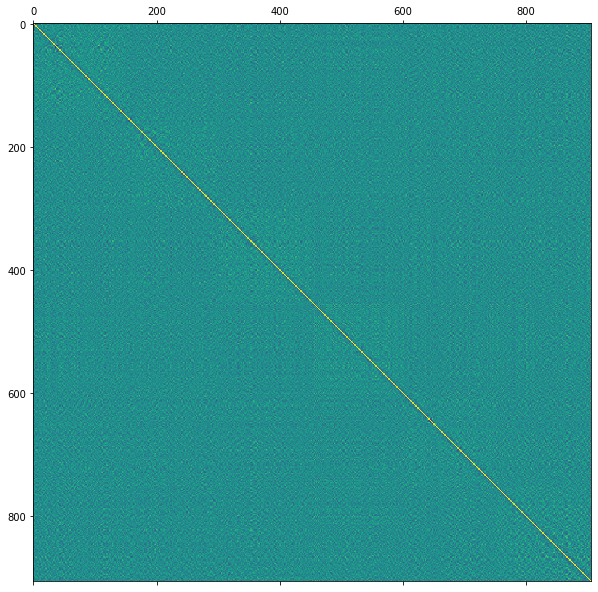

In [7]:
plt.matshow(this_auto_rsa)

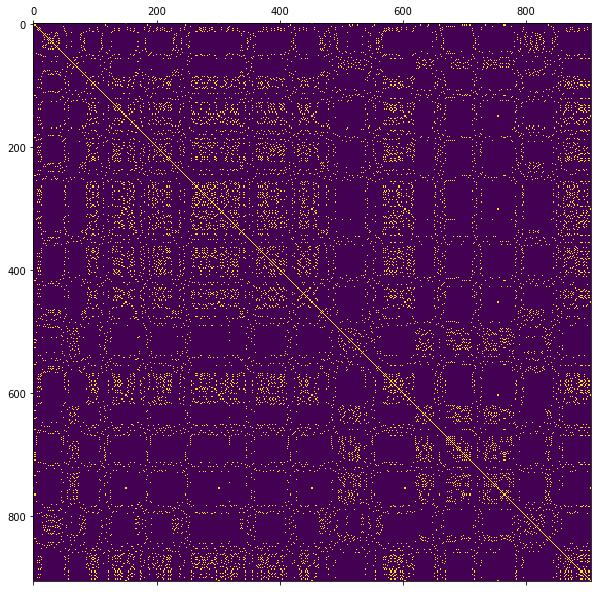

In [8]:
# SAME OBJECT / DIFF OBJECT
plt.matshow(same_object)

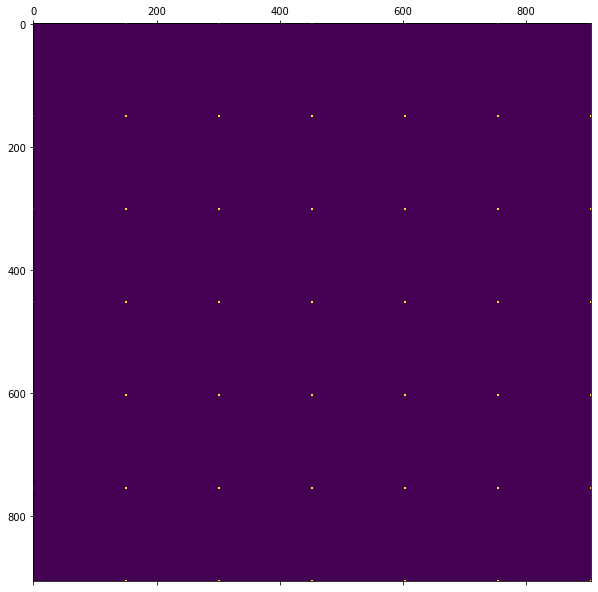

In [9]:
# NaN (Fix) / OBJECT
plt.matshow(nan_comp_itself)

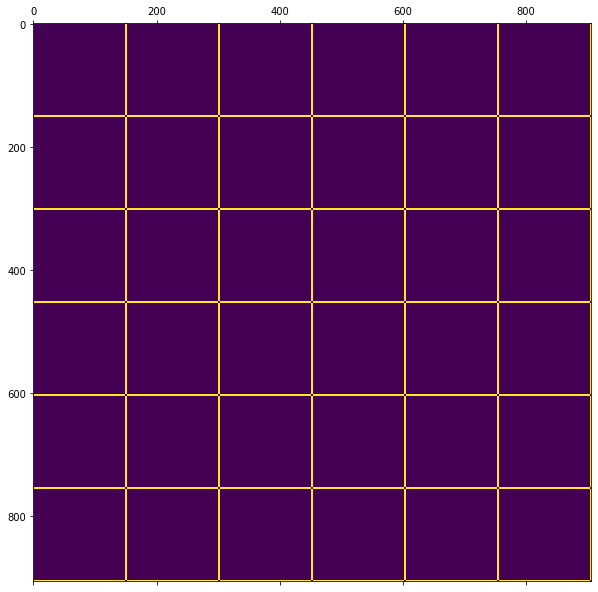

In [10]:
# NaN (Fix) / OBJECT
plt.matshow(nan_comp_others)

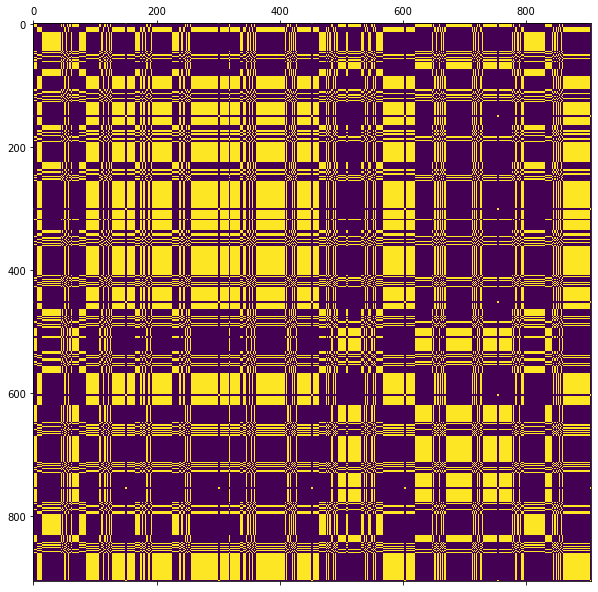

In [11]:
# WITHIN-COMMUNITY (same) / ACROSS-COMMUNITY (diff)
plt.matshow(within_comm)

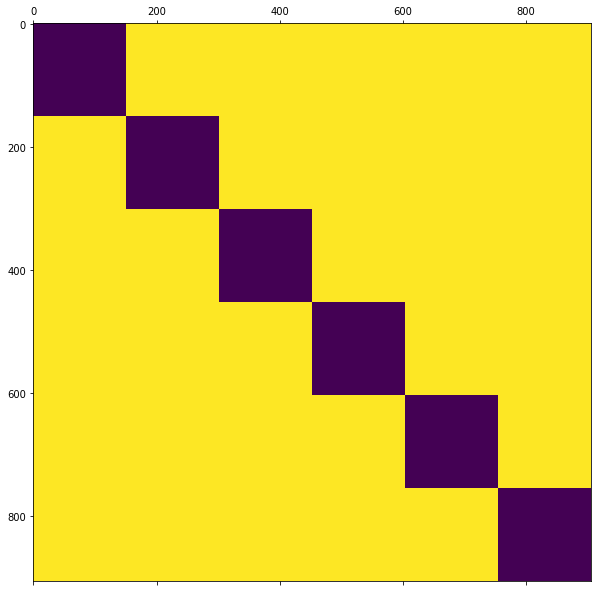

In [12]:
# ACROSS-RUN / WITHIN-RUN
plt.matshow(across_run)

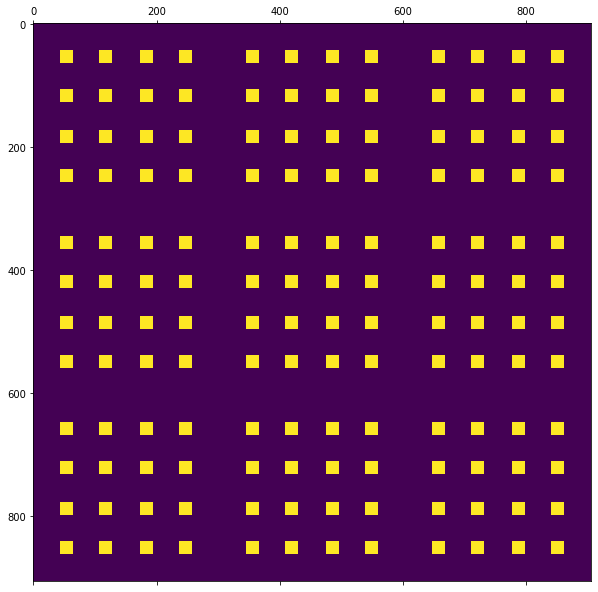

In [13]:
# SCRAMBLED / STRUCTURED
plt.matshow(struct_run)

# Getting overall within-community and across-community means 

In [14]:
within_across_roi_overall_subj = np.array([])
within_across_roi_overall_mean = np.array([])
for r in range(len(rois)): 
    #loop through rois 
    roi = rois[r]
    
    within = []
    across = []
    for s in range(len(subjs)):
        #loop through subjects    
        sub = subjs[s]
        
        #getting RSA for a subject + their ROI
        this_auto_rsa = rsa.load_rsa(data_dir, sub, roi)

        run_all_items = []
        run_all_nans = []
        run_all_comms = []
        run_all_runs = []
        run_all_seqs = []
        
        for run in list(range(1, 7)):
            this_run_info = util.load_struct_run_info(event_dir, sub, run)
    
            #appending items/objects across all runs
            this_run_items = this_run_info.item
            run_all_items.extend(this_run_items)
    
            #appending item communities across all runs 
            this_run_comms = this_run_info.comm
            run_all_comms.extend(this_run_comms)
    
            #appending run nums across all runs
            this_run_nums = this_run_info.run
            run_all_runs.extend(this_run_nums)
    
            #appending sequence types across all runs 
            this_run_seqs = this_run_info.seq_type
            run_all_seqs.extend(this_run_seqs) 
        
        #assigning the 906 x 906 matrix with identifiers that indicate: 
        
        #same object = true 
        #different object = false
        run_all_items_array = np.array(run_all_items)
        same_object = rsa.pair_eq(run_all_items_array) 
        
        #NaN fix = true
        #object = false
        nan_comp_itself = rsa.pair_and(run_all_items_array==0)

        #NaN fix = true
        #object = false
        nan_comp_others = rsa.pair_neq(run_all_items_array==0)
        
        #within community = true 
        #across community = false
        run_all_comm_array = np.array(run_all_comms)
        within_comm = rsa.pair_eq(run_all_comm_array)

        #across run = true
        #within run = false         
        run_all_runs_array = np.array(run_all_runs)
        across_run = rsa.pair_neq(run_all_runs_array)

        #scram = true
        #struct = false 
        run_all_seqs_array = np.array(run_all_seqs)
        scram_run = rsa.pair_and(run_all_seqs_array==2)


        within_comm_sim = this_auto_rsa[(same_object == False) & (nan_comp_itself == False) & (nan_comp_others == False) & (within_comm == True) & (across_run == True) & (scram_run == True)]
        across_comm_sim = this_auto_rsa[(same_object == False) & (nan_comp_itself == False ) & (nan_comp_others == False) & (within_comm == False) & (across_run == True) & (scram_run == True)]
    
        within_comm_sim_mean = np.nanmean(within_comm_sim)
        across_comm_sim_mean = np.nanmean(across_comm_sim)
        
        within.append(within_comm_sim_mean)
        across.append(across_comm_sim_mean)
        
    #by ROI
    within_roi_mean = np.mean(within)
    across_roi_mean = np.mean(across)
    
    within_across_roi_mean = np.column_stack([within_roi_mean, across_roi_mean])
    within_across_roi_all = np.column_stack([within, across])
    
    if r == 0:
        within_across_roi_overall_mean =  within_across_roi_mean
        within_across_roi_mean_tog_all = within_across_roi_all
    else:
        within_across_roi_overall_mean = np.concatenate([within_across_roi_overall_mean, within_across_roi_mean])
        within_across_roi_mean_tog_all = np.concatenate([within_across_roi_mean_tog_all, within_across_roi_all], axis=1)

In [15]:
within_across_roi_overall_mean

array([[0.00114995, 0.0005563 ],
       [0.00209992, 0.00151767],
       [0.00259138, 0.00261232],
       [0.00255146, 0.00207911],
       [0.0005352 , 0.00051988],
       [0.00179827, 0.00142455],
       [0.00164431, 0.00258293],
       [0.00188433, 0.00170687],
       [0.00195319, 0.00068119],
       [0.00250517, 0.00196826],
       [0.00278763, 0.00244977],
       [0.00310043, 0.00245805]])

In [16]:
#MEAN ROI + WITHIN/ACROSS 
roi_mean_sim_df = pd.DataFrame(within_across_roi_overall_mean,
                  index=[rois],
                  columns=['within', 'across'])

roi_mean_sim_df

,within,across
b_hip_ant,0.001150,0.000556
b_hip_body,0.002100,0.001518
b_hip_tail,0.002591,0.002612
b_hip,0.002551,0.002079
l_hip_ant,0.000535,0.000520
l_hip_body,0.001798,0.001425
l_hip_tail,0.001644,0.002583
l_hip,0.001884,0.001707
r_hip_ant,0.001953,0.000681
r_hip_body,0.002505,0.001968


In [17]:
roi_mean_sim_df.to_csv(os.path.join(avg_data_dir, r'allevents_scrambled_roi_WithinAcross_Overall.csv'), index=True)  

In [18]:
within_across_roi_mean_tog_all

array([[ 1.73396141e-03,  1.32312451e-03,  8.75703489e-04,
        -2.82690393e-04,  5.85096551e-03,  7.38036426e-03,
         2.73580164e-03,  2.74981247e-03,  1.48545599e-03,
         3.70405722e-04,  1.84487069e-03,  6.19207582e-04,
         7.88327201e-03,  9.53857679e-03,  3.37990381e-03,
         2.80079020e-03,  2.91625776e-03,  3.21164298e-03,
         4.03260542e-04, -6.46998246e-04,  1.55135049e-03,
         2.21325184e-03,  2.31273002e-03,  2.76319704e-03],
       [ 2.49488198e-03,  6.30299860e-04,  1.55154735e-03,
         2.41577259e-03,  4.04101644e-03,  2.41006307e-03,
         2.46126951e-03,  1.79759911e-03,  3.41539686e-03,
         9.15126652e-04,  8.91197230e-04,  1.23066336e-03,
         3.42836572e-03,  5.09106048e-03,  3.19813683e-03,
         2.77687797e-03, -4.08298307e-05,  1.82244583e-03,
         2.24482335e-03,  3.98699004e-03,  5.60033731e-03,
        -4.53075495e-04,  8.60034481e-04,  1.29679815e-03],
       [ 2.49445417e-04,  1.46066104e-04, -1.68095202e

In [19]:
#MEAN ROI + WITHIN/ACROSS x SUBJECT:
roi_mean_subj_sim_df = pd.DataFrame(within_across_roi_mean_tog_all, index=[subjs_np], columns=conditions_array)
roi_mean_subj_sim_df

b_hip_ant           b_hip_body           b_hip_tail               b_hip  \
       within    across     within    across     within    across    within   
100  0.001734  0.001323   0.000876 -0.000283   0.005851  0.007380  0.002736   
101  0.002495  0.000630   0.001552  0.002416   0.004041  0.002410  0.002461   
102  0.000249  0.000146  -0.001681  0.001892   0.000023  0.002415 -0.000394   
103 -0.002936 -0.000168   0.000403  0.001316  -0.004055 -0.002012 -0.001894   
104  0.000837 -0.000524   0.001846  0.000321   0.002023  0.002100  0.001697   
105  0.001124  0.000114   0.001595  0.000393   0.003101  0.004536  0.002780   
106  0.004175  0.001539   0.001458  0.002259  -0.001294  0.000876  0.002252   
107 -0.000086 -0.001131   0.002171  0.001170  -0.000163  0.003350  0.002546   
108 -0.002219  0.000261   0.002640  0.005106   0.006088  0.005679  0.001076   
109 -0.001545 -0.000866   0.001425 -0.001223   0.003271  0.000705  0.000717   
110  0.002417  0.001612   0.004531  0.002309   0.004388  0.004230  0.003423   
111  0.001442  0.001696   0.005444  0.005032   0.000684 -0.002081  0.002184   
112  0.000772  0.001839   0.001634 -0.001169   0.001461  0.000466  0.001578   
113  0.005008 -0.000483   0.006822  0.004151   0.005802 -0.000375  0.005076   
114  0.005280  0.000551   0.001346  0.004628   0.003088  0.003406  0.004602   
115  0.000703 -0.000135  -0.002441  0.000797   0.002887  0.002558  0.001023   
116  0.000766 -0.002121   0.006390  0.004035   0.008029  0.009751  0.006390   
117  0.000727  0.000844   0.004669  0.001646   0.012256  0.011523  0.010194   
119 -0.000383 -0.000235   0.000596 -0.000530  -0.000909  0.001713  0.000610   
120  0.001620 -0.000703   0.000604 -0.000084   0.001369  0.002585  0.001341   
121  0.001420 -0.001531   0.002178  0.000704   0.003674  0.001404  0.002162   
122  0.000169  0.001086  -0.003150 -0.000573   0.003020 -0.001572  0.000412   
123 -0.000253  0.001485  -0.000382  0.000139   0.001897  0.001016  0.000647   
124 -0.001897  0.000064  -0.001487  0.002738   0.003434  0.000640 -0.000423   
125 -0.002096 -0.000359   0.002255  0.000719  -0.002166 -0.000572 -0.000538   
126  0.000237  0.000231   0.001917 -0.000619   0.000497  0.000847  0.001353   
127  0.000141  0.000728  -0.001321  0.000637   0.000108  0.001210 -0.000691   
128 -0.002181  0.000166  -0.004162  0.000563  -0.001626  0.001550 -0.002380   
129  0.006024 -0.000509   0.011873  0.002552   0.000799  0.000519  0.008756   
130 -0.000781  0.001337  -0.005602  0.003489   0.000143  0.003608 -0.001979   
131  0.008015  0.007948   0.010956  0.008798   0.004636  0.006757  0.010871   
132  0.001271 -0.000143   0.001280 -0.002404   0.000700  0.000567  0.001175   
133  0.002778  0.000059   0.003621  0.002203   0.010223  0.006617  0.005965   
135  0.002988  0.001748   0.006296 -0.003538   0.005005  0.005945  0.005499   
136  0.002404  0.000584   0.006097  0.004982   0.001724  0.000960  0.005589   
137  0.001916  0.001401   0.002455  0.000467   0.002165  0.004220  0.004945   
138  0.000213  0.002100   0.002991  0.001113   0.003708  0.001722  0.002641   

              l_hip_ant            ...     l_hip           r_hip_ant  \
       across    within    across  ...    within    across    within   
100  0.002750  0.001485  0.000370  ...  0.003380  0.002801  0.002916   
101  0.001798  0.003415  0.000915  ...  0.003198  0.002777 -0.000041   
102  0.001838 -0.000512  0.000910  ... -0.000855  0.002650  0.001999   
103  0.000166 -0.003477 -0.000741  ... -0.001675  0.000149 -0.001047   
104  0.000695  0.000566 -0.001903  ...  0.001259 -0.002030  0.000024   
105  0.002043  0.004957  0.000092  ...  0.003597  0.001149 -0.002286   
106  0.002444  0.006683  0.004240  ...  0.003445  0.003903  0.000920   
107  0.001423 -0.002361 -0.001617  ...  0.000315  0.000322  0.002903   
108  0.003055  0.000670  0.000607  ...  0.002281  0.003836 -0.005075   
109 -0.000209 -0.002345 -0.001950  ...  0.002598 -0.000840 -0.000125   
110  0.002419  0.002264  0.002301  ...  0.000890  0.000677

In [20]:
roi_mean_subj_sim_df.to_csv(os.path.join(avg_data_dir, r'allevents_scrambled_roi_WithinAcross_Subject.csv'), index=True)  

# Getting overall item by item comparisons

In [6]:
for r in range(len(rois)): 
    #loop through rois 
    
    roi = rois[r]
    #print(roi)
    
    roi_dir = os.path.join(avg_data_dir,roi)
    if not os.path.exists(roi_dir):
        os.makedirs(roi_dir)
    
    roi_sum_mat = np.zeros((21,21))
    roi_count_mat = np.zeros((21,21))
    roi_overall_sum = np.zeros((21,21))
    
    for s in range(len(subjs)):
        #loop through subjects   
        
        sub = subjs[s]
        #print(sub)
        
        roi_subj_sum_mat = np.zeros((21,21))
        roi_subj_count_mat = np.zeros((21,21))
        
        #getting RSA for a subject + their ROI
        this_auto_rsa = rsa.load_rsa(data_dir, sub, roi)
        
        run_all_items = []
        run_all_runs = []
        run_all_seqs = []  
        for run in list(range(1, 7)):
            #loop through runs
            
            #print(run)
            this_run_info = util.load_struct_run_info(event_dir, sub, run)
            
            #appending items/objects across all runs
            this_run_items = this_run_info.item
            run_all_items.extend(this_run_items)
    
            #appending run nums across all runs
            this_run_nums = this_run_info.run
            run_all_runs.extend(this_run_nums)
    
            #appending sequence types across all runs 
            this_run_seqs = this_run_info.seq_type
            run_all_seqs.extend(this_run_seqs) 
      
        #assigning the 906 x 906 matrix with identifiers that indicate: 
        
        #same object = true 
        #different object = false
        run_all_items_array = np.array(run_all_items)
        same_object = rsa.pair_eq(run_all_items_array) 
        
        #NaN fix = true
        #object = false
        nan_comp_itself = rsa.pair_and(run_all_items_array==0)

        #NaN fix = true
        #object = false
        nan_comp_others = rsa.pair_neq(run_all_items_array==0)
        
        #across run = true
        #within run = false         
        run_all_runs_array = np.array(run_all_runs)
        across_run = rsa.pair_neq(run_all_runs_array)

        #scram = true
        #struct = false 
        run_all_seqs_array = np.array(run_all_seqs)
        scram_run = rsa.pair_and(run_all_seqs_array==2) 
        
        for x in range(len(run_all_items)):
            x_item = run_all_items[x] - 1
            
            for y in range(len(run_all_items)):
                y_item = run_all_items[y] - 1
                
                if x_item > -1 and y_item > -1:
                    rsa_val = this_auto_rsa[x, y]
                
                    item_tf = same_object[x, y]
                    nan_itself_tf = nan_comp_itself[x, y]
                    nan_others_tf = nan_comp_others[x, y]
                    run_tf = across_run[x, y]   
                    scram_tf = scram_run[x, y]
                    
                    if item_tf == False and nan_itself_tf == False and nan_others_tf == False and run_tf == True and scram_tf == True:
                        roi_subj_sum_mat[x_item, y_item] = roi_subj_sum_mat[x_item, y_item] + rsa_val
                        roi_subj_count_mat[x_item, y_item] = roi_subj_count_mat[x_item, y_item] + 1
                    
        os.chdir(roi_dir)
        roi_subj_avg = roi_subj_sum_mat/roi_subj_count_mat
        #figure out how to add multiple subject matracies into one to eventually average
        
        roi_overall_sum = roi_overall_sum + roi_subj_avg
        
        name_subj = str(sub) + '_' + roi + '_allevents_scrambled' +'_ItemSim.csv'
        np.savetxt(name_subj, roi_subj_avg, delimiter=",")

    #by ROI
    roi_overall_avg = roi_overall_sum/len(subjs)
    name_overall = 'overall_' + roi + '_allevents_scrambled' +'_ItemSim.csv'
    np.savetxt(name_overall, roi_overall_avg, delimiter=",") 

/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor_analyses/tesser_successor/tesser/util.py:105: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  run_info = pd.read_csv(run_file, sep='\,', skipinitialspace=True, header=None)
<ipython-input-6-017ef485f7fd>:93: RuntimeWarning: invalid value encountered in true_divide
  roi_subj_avg = roi_subj_sum_mat/roi_subj_count_mat


In [ ]:
plt.matshow(roi_subj_avg)

In [ ]:
plt.matshow(roi_overall_avg)

In [5]:
this_run_info

,trial_num,onset,TR,seq_type,item,dur,run,comm
0,1,0,0,0,0,0,1,NaN
1,2,2,1,0,0,0,1,NaN
2,3,4,2,1,18,0,1,1
3,4,6,3,1,20,0,1,1
4,5,12,6,1,3,0,1,1
...,...,...,...,...,...,...,...,...
146,147,580,290,1,5,0,1,2
147,148,586,293,1,7,0,1,2
148,149,590,295,1,8,0,1,2
149,150,592,296,0,0,0,1,NaN
